In [1]:
import openmc
import matplotlib.pyplot as plt
import openmc.deplete
import os
import numpy as np

path = '/root/jeff-3.3-hdf5/cross_sections.xml'

## In this notebook a 17x17 fuel bundle with burnable absorber coated fuel pins like those found in AP1000s are modelled, and fuel burn-up calculations are done with openmc.deplete module

Material compositions and reactor geometry 

In [2]:
#------ Materials -------#

# radii of reactor elements
fuel_radius = 0.409595
ba_radius = 0.412155

clad_inner_radius = 0.417830
clad_outer_radius = 0.474980 # according to IAEA fuel rod radius is 9.5 mm

# fuel: enriched uranium dioxide

uo2 = openmc.Material(1,'uo2_high',temperature=1200)
uo2.add_nuclide('U235', 0.0445)
uo2.add_nuclide('U238', 0.9555)
uo2.add_nuclide('O16', 2.0)
uo2.set_density('g/cm3', 10.4668)
uo2.volume = np.pi*fuel_radius**2 # for burn-up calculation

# burnable absorber: ZrB2
ba = openmc.Material(2, 'BA')
ba.add_element('Zr', 1.0)
ba.add_element('B', 2.0)
ba.set_density('g/cm3', 5.42) # according to Mohamed et al
ba.volume = np.pi*(ba_radius-fuel_radius)**2 # for burn-up calculation

# clad: zirconium
clad = openmc.Material(3, 'zirconium',temperature=600)
clad.add_element('Zr', 1.0)
clad.set_density('g/cm3', 6.55) # according to Mohamed et al

# clad: Optimized ZIRLO 
clad_2 = openmc.Material(4, 'ZIRLO',temperature=600)
clad_2.add_element('Zr', 0.983)
clad_2.add_element('Sn', 0.01)
clad_2.add_element('Nb', 0.007)
clad_2.set_density('g/cm3', 6.55) # according to Mohamed et al

# water
water = openmc.Material(5, 'h2o')
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 0.75)
water.add_s_alpha_beta('c_H_in_H2O')

materials = openmc.Materials([uo2, ba, clad, water])
materials.cross_sections = path
materials.export_to_xml()

In [32]:
# create a fuel pin Universe

pitch = 1.12
pin_cell_box = openmc.model.RectangularPrism(width=pitch, height=pitch) # little box around fuel pin

fuel_pin = openmc.ZCylinder(r=fuel_radius)
clad_inner = openmc.ZCylinder(r=clad_inner_radius)
clad_outer = openmc.ZCylinder(r=clad_outer_radius)

fuel_region = -fuel_pin
air_region = +fuel_pin & -clad_inner
clad_region = +clad_inner & -clad_outer
coolant_region = +clad_outer & -pin_cell_box

fuel = uo2

fuel_cell = openmc.Cell(fill=fuel, region=fuel_region)
gap_cell = openmc.Cell(region=air_region)
clad_cell = openmc.Cell(fill=clad, region=clad_region)
coolant_cell = openmc.Cell(fill=water,region=coolant_region)

# we define the x and y planes with boundary condition
left = openmc.XPlane(x0=-pitch)
right = openmc.XPlane(x0=pitch)
bottom = openmc.YPlane(y0=-pitch)
top = openmc.YPlane(y0=pitch)

f = openmc.Universe(cells=[fuel_cell, gap_cell, clad_cell, coolant_cell]) # fuel universe

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

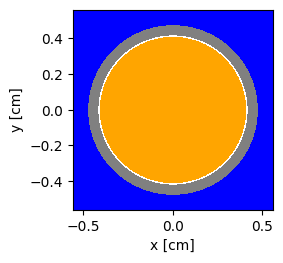

In [33]:
f.plot(pixels=[200,200], colors={fuel_cell:'orange',clad_cell:'grey',gap_cell:'white',coolant_cell:'blue'})

In [34]:
# new fuel pin universe for BA coated fuel (apparently, OpenMC wants two universes, one for each type of fuel pin)

pin_cell_box_ba = openmc.model.RectangularPrism(width=pitch, height=pitch) # little box around fuel pin

fuel_pin_ba = openmc.ZCylinder(r=fuel_radius)
ba_outer = openmc.ZCylinder(r=ba_radius)
clad_inner_ba = openmc.ZCylinder(r=clad_inner_radius)
clad_outer_ba = openmc.ZCylinder(r=clad_outer_radius)

fuel_region_ba = -fuel_pin_ba
ba_region = +fuel_pin_ba & -ba_outer
air_region_ba = +ba_outer & -clad_inner_ba
clad_region_ba = +clad_inner_ba & -clad_outer_ba
coolant_region_ba = +clad_outer & -pin_cell_box_ba

fuel = uo2

fuel_cell_ba = openmc.Cell(fill=fuel, region=fuel_region_ba)
ba_cell = openmc.Cell(fill=ba, region=ba_region)
gap_cell_ba = openmc.Cell(region=air_region_ba)
clad_cell_ba = openmc.Cell(fill=clad, region=clad_region)
coolant_cell_ba = openmc.Cell(fill=water,region=coolant_region)

# we define the x and y planes with boundary condition
left_ba = openmc.XPlane(x0=-pitch)
right_ba = openmc.XPlane(x0=pitch)
bottom_ba = openmc.YPlane(y0=-pitch)
top_ba = openmc.YPlane(y0=pitch)

fba = openmc.Universe(cells=[fuel_cell_ba, ba_cell, gap_cell_ba, clad_cell_ba, coolant_cell_ba]) # fuel universe

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

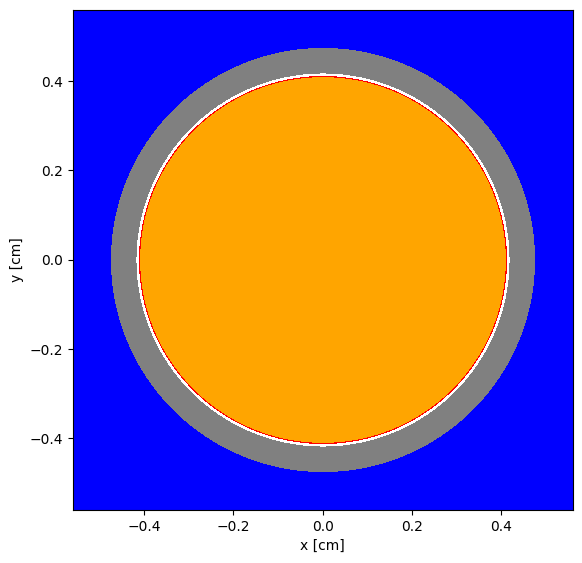

In [35]:
fba.plot(pixels=[500,500],colors={fuel_cell_ba:'orange', ba_cell:'red',coolant_cell_ba:'green',clad_cell_ba:'grey',gap_cell_ba:'white',coolant_cell_ba:'blue'})

In [136]:
# define a 17x17 lattice and put in fuel pins on each lattice point
lattice = openmc.RectLattice()
lattice.pitch = (pitch,pitch)
lattice.lower_left = (0,0)
#lattice.lower_left = (-8*pitch, 8*pitch)  # Set lower-left corner of the lattice

n = 17
lattice_shape = (n, n)

lattice.universes = [
    #[f]*n,[f]*n,[f]*n,[f]*n,[f]*n,[f]*n,[f]*n,[f]*n,[f]*n,[f]*n,[f]*n,[f]*n,[f]*n,[f]*n,[f]*n,[f]*n,[f]*n # no BA setup
]
lattice.universes = [
    [fba,fba,f,f,f,f,f,f,f,f,f,f,f,f,f,fba,fba],
    [fba,f,f,f,f,fba,f,f,fba,f,f,fba,f,f,f,f,fba],
    [f,f,f,f,fba,f,f,fba,f,fba,f,f,fba,f,f,f,f],
    [f,f,f,f,fba,f,f,f,f,f,f,f,fba,f,f,f,f],
    [f,f,fba,fba,f,fba,f,f,fba,f,f,fba,f,fba,fba,f,f],
    [f,fba,f,f,fba,f,f,fba,f,fba,f,f,fba,f,f,fba,f],
    [f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f],
    [f,f,fba,f,f,fba,f,f,fba,f,f,fba,f,f,fba,f,f],
    [f,fba,f,f,fba,f,f,fba,f,fba,f,f,fba,f,f,fba,f],
    [f,f,fba,f,f,fba,f,f,fba,f,f,fba,f,f,fba,f,f],
    [f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f],
    [f,fba,f,f,fba,f,f,fba,f,fba,f,f,fba,f,f,fba,f],
    [f,f,fba,fba,f,fba,f,f,fba,f,f,fba,f,fba,fba,f,f],
    [f,f,f,f,fba,f,f,f,f,f,f,f,fba,f,f,f,f],
    [f,f,f,f,fba,f,f,fba,f,fba,f,f,fba,f,f,f,f],
    [fba,f,f,f,f,fba,f,f,fba,f,f,fba,f,f,f,f,fba],
    [fba,fba,f,f,f,f,f,f,f,f,f,f,f,f,f,fba,fba]
] # BA setup


# boundary of assembly
xmin = openmc.XPlane(x0=0) # lower left corner in (0,0)
xmax = openmc.XPlane(x0=pitch*n)
ymin = openmc.YPlane(y0=0)
ymax = openmc.YPlane(y0=pitch*n)

assembly_boundary = +xmin & -xmax & +ymin & -ymax
assembly_cell = openmc.Cell(fill=lattice, region=assembly_boundary) # lattice works as a material 
assembly_box = openmc.model.RectangularPrism(width=pitch*(n), height=pitch*(n),origin=(pitch*n/2,pitch*n/2)) # boundary of assembly
assembly_universe = openmc.Universe(cells=[assembly_cell])

# outer boundary
p = 2 # width of water area
xmin_all = openmc.XPlane(x0=-pitch-p, boundary_type='reflective')
xmax_all = openmc.XPlane(x0=pitch*(n+1)+p, boundary_type='reflective')
ymin_all = openmc.YPlane(y0=-pitch-p, boundary_type='reflective')
ymax_all = openmc.YPlane(y0=pitch*(n+1)+p, boundary_type='reflective')

water_region = +xmin_all & -xmax_all & +ymin_all & -ymax_all & +assembly_box
moderator_cell = openmc.Cell(fill=water, region=water_region)

root_universe = openmc.Universe(cells=[assembly_cell, moderator_cell])

geometry = openmc.Geometry(root_universe)
geometry.root_universe = root_universe
geometry.export_to_xml()

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

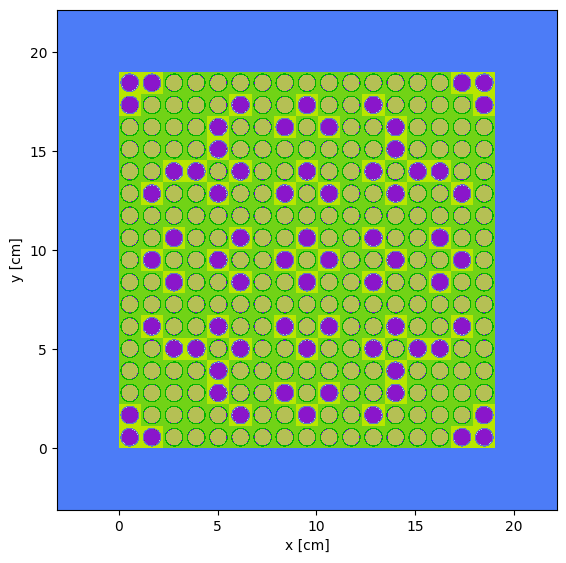

In [137]:
root_universe.plot(pixels=[500,500])

In [124]:
# state point file and settings for simulation
point = openmc.stats.Point((0, 0, 0))
src = openmc.Source(space=point)

settings = openmc.Settings()
settings.source = src
settings.batches = 100
settings.inactive = 10
settings.particles = 500
settings.export_to_xml()

/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [10]:
import os
os.system('rm *h5') # delete previous results

openmc.run() # run simulation

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [11]:
# run a depletion calculation
model = openmc.model.Model(geometry, materials, settings)

operator = openmc.deplete.CoupledOperator(model, '/root/data/depletion/chain_casl_pwr.xml')

powdens = 40.2 #W/gHM source: IAEA

burnup_steps = np.array([25,25,50,100,100,100,100,100,100]) # days

integrator = openmc.deplete.PredictorIntegrator(operator, timesteps=burnup_steps,
                                                power_density=powdens,timestep_units='d')
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mo94 from /root/jeff-3.3-hdf5/Mo94.h5
 Reading Mo95 from /root/jeff-3.3-hdf5/Mo95.h5
 Reading Mo96 from /root/jeff-3.3-hdf5/Mo96.h5
 Reading Mo97 from /root/jeff-3.3-hdf5/Mo97.h5
 Reading Mo98 from /root/jeff-3.3-hdf5/Mo98.h5
 Reading Mo99 from /root/jeff-3.3-hdf5/Mo99.h5
 Reading Mo100 from /root/jeff-3.3-hdf5/Mo100.h5
 Reading Tc99 from /root/jeff-3.3-hdf5/Tc99.h5


          1200K
          2500K


 Reading Ru100 from /root/jeff-3.3-hdf5/Ru100.h5
 Reading Ru101 from /root/jeff-3.3-hdf5/Ru101.h5
 Reading Ru102 from /root/jeff-3.3-hdf5/Ru102.h5
 Reading Ru103 from /root/jeff-3.3-hdf5/Ru103.h5
 Reading Ru104 from /root/jeff-3.3-hdf5/Ru104.h5
 Reading Ru105 from /root/jeff-3.3-hdf5/Ru105.h5
 Reading Ru106 from /root/jeff-3.3-hdf5/Ru106.h5
 Reading Rh102 from /root/jeff-3.3-hdf5/Rh102.h5
 Reading Rh103 from /root/jeff-3.3-hdf5/Rh103.h5
 Reading Rh104 from /root/jeff-3.3-hdf5/Rh104.h5
 Reading Rh105 from /root/jeff-3.3-hdf5/Rh105.h5
 Reading Pd104 from /root/jeff-3.3-hdf5/Pd104.h5
 Reading Pd105 from /root/jeff-3.3-hdf5/Pd105.h5
 Reading Pd106 from /root/jeff-3.3-hdf5/Pd106.h5
 Reading Pd107 from /root/jeff-3.3-hdf5/Pd107.h5
 Reading Pd108 from /root/jeff-3.3-hdf5/Pd108.h5
 Reading Ag107 from /root/jeff-3.3-hdf5/Ag107.h5
 Reading Ag109 from /root/jeff-3.3-hdf5/Ag109.h5
 Reading Ag110 from /root/jeff-3.3-hdf5/Ag110.h5


          1200K
          2500K


 Reading Ag110_m1 from /root/jeff-3.3-hdf5/Ag110_m1.h5
 Reading Ag111 from /root/jeff-3.3-hdf5/Ag111.h5
 Reading Cd110 from /root/jeff-3.3-hdf5/Cd110.h5
 Reading Cd111 from /root/jeff-3.3-hdf5/Cd111.h5
 Reading Cd112 from /root/jeff-3.3-hdf5/Cd112.h5
 Reading Cd113 from /root/jeff-3.3-hdf5/Cd113.h5
 Reading Cd114 from /root/jeff-3.3-hdf5/Cd114.h5
 Reading In113 from /root/jeff-3.3-hdf5/In113.h5
 Reading In115 from /root/jeff-3.3-hdf5/In115.h5
 Reading Sb121 from /root/jeff-3.3-hdf5/Sb121.h5
 Reading Sb123 from /root/jeff-3.3-hdf5/Sb123.h5
 Reading Sb125 from /root/jeff-3.3-hdf5/Sb125.h5
 Reading Sb127 from /root/jeff-3.3-hdf5/Sb127.h5
 Reading Te127_m1 from /root/jeff-3.3-hdf5/Te127_m1.h5
 Reading Te129_m1 from /root/jeff-3.3-hdf5/Te129_m1.h5


          250K
          294K
          600K
          900K
          1200K
          2500K


 Reading Te132 from /root/jeff-3.3-hdf5/Te132.h5
 Reading I127 from /root/jeff-3.3-hdf5/I127.h5
 Reading I128 from /root/jeff-3.3-hdf5/I128.h5
 Reading I129 from /root/jeff-3.3-hdf5/I129.h5
 Reading I130 from /root/jeff-3.3-hdf5/I130.h5
 Reading I131 from /root/jeff-3.3-hdf5/I131.h5
 Reading I135 from /root/jeff-3.3-hdf5/I135.h5
 Reading Xe128 from /root/jeff-3.3-hdf5/Xe128.h5
 Reading Xe130 from /root/jeff-3.3-hdf5/Xe130.h5
 Reading Xe131 from /root/jeff-3.3-hdf5/Xe131.h5
 Reading Xe132 from /root/jeff-3.3-hdf5/Xe132.h5
 Reading Xe133 from /root/jeff-3.3-hdf5/Xe133.h5
 Reading Xe134 from /root/jeff-3.3-hdf5/Xe134.h5
 Reading Xe135 from /root/jeff-3.3-hdf5/Xe135.h5
 Reading Xe135_m1 from /root/jeff-3.3-hdf5/Xe135_m1.h5


          250K
          294K
          600K
          900K
          1200K
          2500K


 Reading Xe136 from /root/jeff-3.3-hdf5/Xe136.h5
 Reading Cs133 from /root/jeff-3.3-hdf5/Cs133.h5
 Reading Cs134 from /root/jeff-3.3-hdf5/Cs134.h5
 Reading Cs135 from /root/jeff-3.3-hdf5/Cs135.h5
 Reading Cs136 from /root/jeff-3.3-hdf5/Cs136.h5
 Reading Cs137 from /root/jeff-3.3-hdf5/Cs137.h5
 Reading Ba134 from /root/jeff-3.3-hdf5/Ba134.h5
 Reading Ba137 from /root/jeff-3.3-hdf5/Ba137.h5
 Reading Ba140 from /root/jeff-3.3-hdf5/Ba140.h5
 Reading La139 from /root/jeff-3.3-hdf5/La139.h5
 Reading La140 from /root/jeff-3.3-hdf5/La140.h5
 Reading Ce140 from /root/jeff-3.3-hdf5/Ce140.h5
 Reading Ce141 from /root/jeff-3.3-hdf5/Ce141.h5
 Reading Ce142 from /root/jeff-3.3-hdf5/Ce142.h5
 Reading Ce143 from /root/jeff-3.3-hdf5/Ce143.h5
 Reading Ce144 from /root/jeff-3.3-hdf5/Ce144.h5
 Reading Pr141 from /root/jeff-3.3-hdf5/Pr141.h5
 Reading Pr142 from /root/jeff-3.3-hdf5/Pr142.h5
 Reading Pr143 from /root/jeff-3.3-hdf5/Pr143.h5
 Reading Nd142 from /root/jeff-3.3-hdf5/Nd142.h5
 Reading Nd143 from 

 Reading Nd150 from /root/jeff-3.3-hdf5/Nd150.h5
 Reading Pm147 from /root/jeff-3.3-hdf5/Pm147.h5
 Reading Pm148 from /root/jeff-3.3-hdf5/Pm148.h5
 Reading Pm148_m1 from /root/jeff-3.3-hdf5/Pm148_m1.h5


          250K
          294K
          600K
          900K
          1200K
          2500K


 Reading Pm149 from /root/jeff-3.3-hdf5/Pm149.h5
 Reading Pm151 from /root/jeff-3.3-hdf5/Pm151.h5
 Reading Sm147 from /root/jeff-3.3-hdf5/Sm147.h5
 Reading Sm148 from /root/jeff-3.3-hdf5/Sm148.h5
 Reading Sm149 from /root/jeff-3.3-hdf5/Sm149.h5
 Reading Sm150 from /root/jeff-3.3-hdf5/Sm150.h5
 Reading Sm151 from /root/jeff-3.3-hdf5/Sm151.h5
 Reading Sm152 from /root/jeff-3.3-hdf5/Sm152.h5
 Reading Sm153 from /root/jeff-3.3-hdf5/Sm153.h5
 Reading Sm154 from /root/jeff-3.3-hdf5/Sm154.h5
 Reading Eu151 from /root/jeff-3.3-hdf5/Eu151.h5
 Reading Eu152 from /root/jeff-3.3-hdf5/Eu152.h5
 Reading Eu152_m1 from /root/jeff-3.3-hdf5/Eu152_m1.h5
 Reading Eu153 from /root/jeff-3.3-hdf5/Eu153.h5
 Reading Eu154 from /root/jeff-3.3-hdf5/Eu154.h5
 Reading Eu155 from /root/jeff-3.3-hdf5/Eu155.h5
 Reading Eu156 from /root/jeff-3.3-hdf5/Eu156.h5
 Reading Eu157 from /root/jeff-3.3-hdf5/Eu157.h5
 Reading Gd152 from /root/jeff-3.3-hdf5/Gd152.h5
 Reading Gd154 from /root/jeff-3.3-hdf5/Gd154.h5
 Reading Gd155

          1200K


 Reading Pu237 from /root/jeff-3.3-hdf5/Pu237.h5
 Reading Pu238 from /root/jeff-3.3-hdf5/Pu238.h5
 Reading Pu239 from /root/jeff-3.3-hdf5/Pu239.h5
 Reading Pu240 from /root/jeff-3.3-hdf5/Pu240.h5
 Reading Pu241 from /root/jeff-3.3-hdf5/Pu241.h5
 Reading Pu242 from /root/jeff-3.3-hdf5/Pu242.h5
 Reading Pu243 from /root/jeff-3.3-hdf5/Pu243.h5
 Reading Am241 from /root/jeff-3.3-hdf5/Am241.h5
 Reading Am242 from /root/jeff-3.3-hdf5/Am242.h5
 Reading Am242_m1 from /root/jeff-3.3-hdf5/Am242_m1.h5
 Reading Am243 from /root/jeff-3.3-hdf5/Am243.h5
 Reading Am244 from /root/jeff-3.3-hdf5/Am244.h5
 Reading Am244_m1 from /root/jeff-3.3-hdf5/Am244_m1.h5
 Reading Cm242 from /root/jeff-3.3-hdf5/Cm242.h5
 Reading Cm243 from /root/jeff-3.3-hdf5/Cm243.h5
 Reading Cm244 from /root/jeff-3.3-hdf5/Cm244.h5
 Reading Cm245 from /root/jeff-3.3-hdf5/Cm245.h5
 Reading Cm246 from /root/jeff-3.3-hdf5/Cm246.h5
 Maximum neutron transport energy: 20000000 eV for B10
 Initializing source particles...

 ===============

/usr/local/lib/python3.9/dist-packages/openmc/deplete/results.py:91: FutureWarning: The ResultsList.from_hdf5(...) method is no longer necessary and will be removed in a future version of OpenMC. Use Results(...) instead.
  warn(


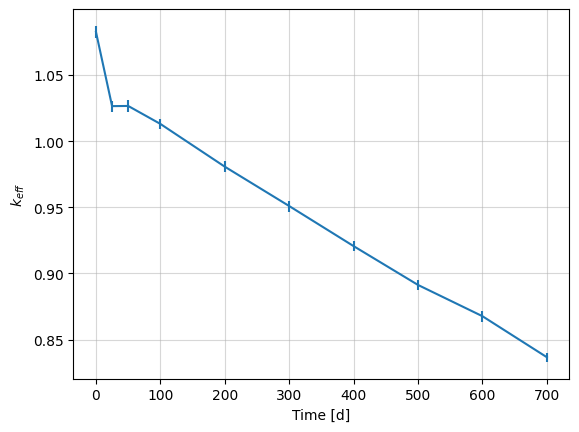

In [12]:
# plot k_eff depletion results
results = openmc.deplete.Results.from_hdf5("depletion_results.h5")
time, k = results.get_keff()
time /= (24 * 60 * 60)  # convert back to days from seconds

plt.errorbar(time, k[:, 0], yerr=k[:, 1])
plt.xlabel('Time [d]')
plt.ylabel('$k_{eff}$')
plt.grid(alpha=0.5)
plt.show()

In [13]:
# different enrichments

'''uo2_mid = openmc.Material(2,'uo2_mid')
uo2_mid.add_nuclide('U235', 0.034)
uo2_mid.add_nuclide('U238', 0.966)
uo2_mid.add_nuclide('O16', 2.0)
uo2_mid.set_density('g/cm3', 10.4668)

uo2_low = openmc.Material(3,'uo2_low')
uo2_low.add_nuclide('U235', 0.0245)
uo2_low.add_nuclide('U238', 0.9755)
uo2_low.add_nuclide('O16', 2.0)
uo2_low.set_density('g/cm3', 10.4668) # according to Mohamad
'''

"uo2_mid = openmc.Material(2,'uo2_mid')\nuo2_mid.add_nuclide('U235', 0.034)\nuo2_mid.add_nuclide('U238', 0.966)\nuo2_mid.add_nuclide('O16', 2.0)\nuo2_mid.set_density('g/cm3', 10.4668)\n\nuo2_low = openmc.Material(3,'uo2_low')\nuo2_low.add_nuclide('U235', 0.0245)\nuo2_low.add_nuclide('U238', 0.9755)\nuo2_low.add_nuclide('O16', 2.0)\nuo2_low.set_density('g/cm3', 10.4668) # according to Mohamad\n"

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

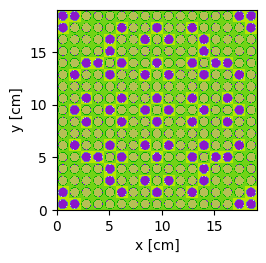

In [151]:
assembly_universe.plot()

In [166]:
# define a 17x17 lattice and put in fuel pins on each lattice point

assembly_size = pitch*n*2
lattice_2 = openmc.RectLattice()
lattice_2.pitch = (assembly_size, assembly_size)
lattice_2.lower_left = (0,0)  # Set lower-left corner of the lattice

m = 3
lattice_2_shape = (m, m)
lattice_2.universes = [
    [assembly_universe,assembly_universe,assembly_universe],
    [assembly_universe,assembly_universe,assembly_universe],
    [assembly_universe,assembly_universe,assembly_universe]
] # BA setup

# boundary of assembly
xmin2 = openmc.XPlane(x0=0) # lower left corner in (0,0)
xmax2 = openmc.XPlane(x0=assembly_size*m)
ymin2 = openmc.YPlane(y0=0)
ymax2 = openmc.YPlane(y0=assembly_size*m)

full_boundary = +xmin2 & -xmax2 & +ymin2 & -ymax2
reactor_core_cell = openmc.Cell(fill=lattice_2,region=full_boundary) # lattice works as a material
reactor_core_universe = openmc.Universe(cells=[reactor_core_cell])

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

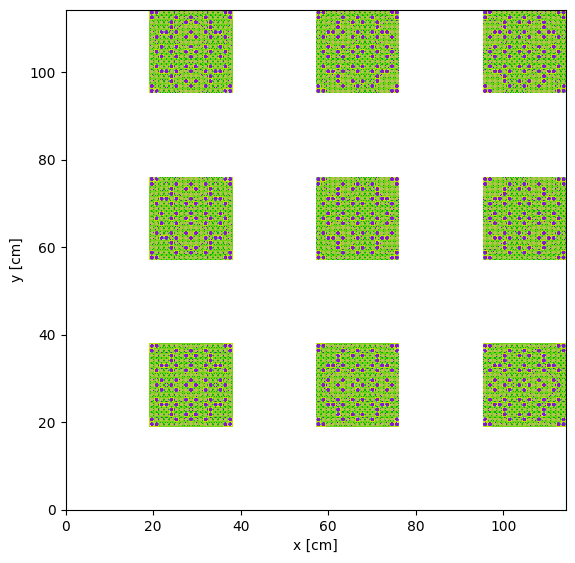

In [168]:
reactor_core_universe.plot(pixels=[500,500])